In [16]:
%matplotlib widget
# %matplotlib inline

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [18]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

### Set save data

In [19]:
save_data = False

In [20]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [21]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_240617


In [22]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
config_path = os.path.join('S:\Seb\experiements\qram_tprocv1_expts\configs', config_file)
print('Config will be', config_path)

Config will be S:\Seb\experiements\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [23]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [24]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

print(list(im))
# print(im)

['Pyro.NameServer', 'Heman', 'qdac', 'bkp', 'Qick60', 'SC_26C1', 'SC_2FF1', 'scqubA', 'scredA', 'scqubB', 'scredB', 'YOKO4', 'RS', 'Qick187']


In [25]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

# Qubit/resonator to probe

In [742]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [747]:
qubit_i = 1
results_Qi = all_results[qubit_i]

## Set reps and rounds

In [748]:
reps = 100
rounds = 10

# Resonator spectro

In [786]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))



span = 15 # MHz
npts = 200
rspec.cfg.expt = dict(
    start= 5794.96-0.5*span, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
)
rspec.cfg.device.readout.gain[qubit_i] = 0.8
rspec.cfg.device.readout.readout_length = 3
rspec.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/200 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 0.7051676291907285
[5794.922500000001, 28974.612500000003, 28974.612500000003, 0, 0.0015043578202001227, 0]
Attempted to init fitparam 5 to 0, which is out of bounds 0 to 1.0026317358739436. Instead init to 0.5013158679369718
[5.80147902e+03 1.25779686e+03 3.39806705e+04 7.10927439e-01
 2.25653673e-03 3.26395252e-41]

Freq with minimum transmission: 5788.96
Freq with maximum transmission: 5793.16
From fit:
	f0: 5801.479020361993
	Qi: 1257.796861911024 	 kappa_i/2pi: 4.612413336401206
	Qe: 33980.67053350641 	 kappa_e/2pi: 0.17072879755687823
	Q0: 1212.9012389521504
	kappa [MHz]: 4.783142133958084
	phi [radians]: 0.7109274394860416


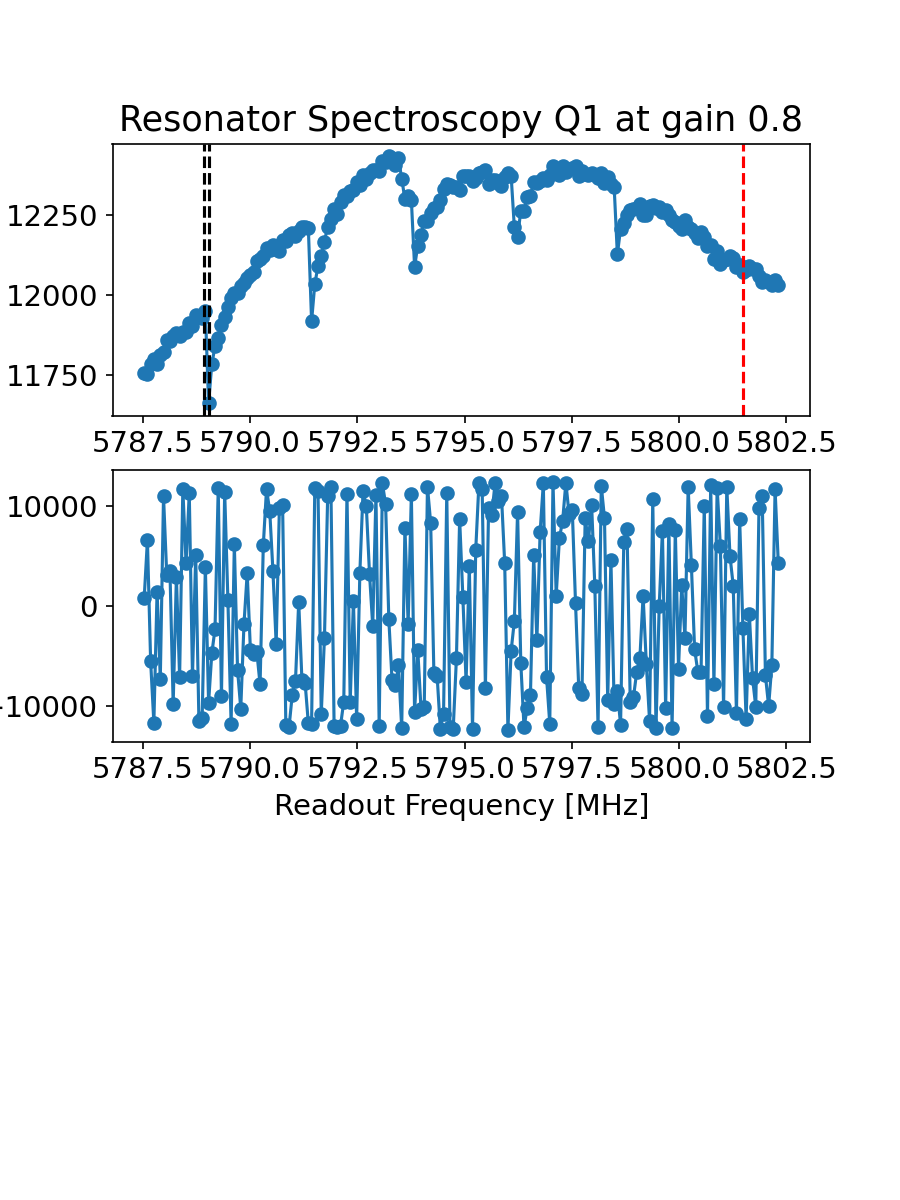

*Set cfg res 1 freq to 5789.035*
*Set cfg res 1 gain to 0.8*
qubit 1 {'Res freq': 5789.035, 'Res freq (yaml)': 5789.035, 'Res kappa': 4.783142133958084}


In [788]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=False)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

res_freq_g = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# res_freq_g = rspec.data['xpts'][np.argmax(rspec.data['amps'])]
yaml_cfg.device.readout.frequency[qubit_i] = res_freq_g

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i])})
results_Qi.update({'Res freq (yaml)':yaml_cfg.device.readout.frequency[qubit_i]})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(f'qubit {qubit_i}', results_Qi)

# Spectro versus power

In [792]:
span_f = 6 # MHz
npts_f = 200

stop_gain = 0.01
start_gain = 0.6
npts_gain = 10

step_gain = (stop_gain - start_gain)/npts_gain

reps = 100



### Ground state

In [793]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

rpowspec.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_gain=start_gain, # Gain start value
    step_gain=step_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=reps, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 3

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.01, 0.03, 0.01, 0.035], 'readout_length': 3, 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': 300}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.497481224433, 4572.395355534644, 0.0, 4211.655959517836, 4207.2388111170285, 0.0, 4209.981140744554], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.908045977012, 

  0%|          | 0/11 [00:00<?, ?it/s]

qubit 1


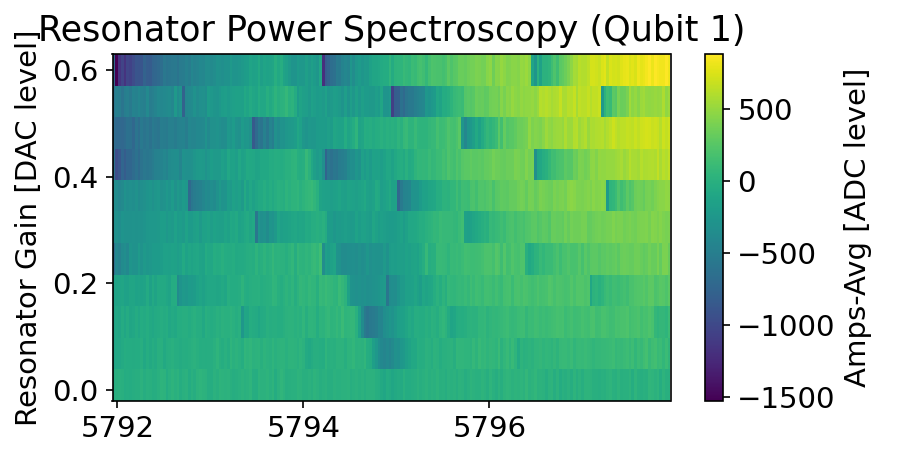

plotting at gain 0.6 index 0
plotting at gain 0.6 index 0
plotting at gain 0.6 index 0
plotting at gain 0.6 index 0


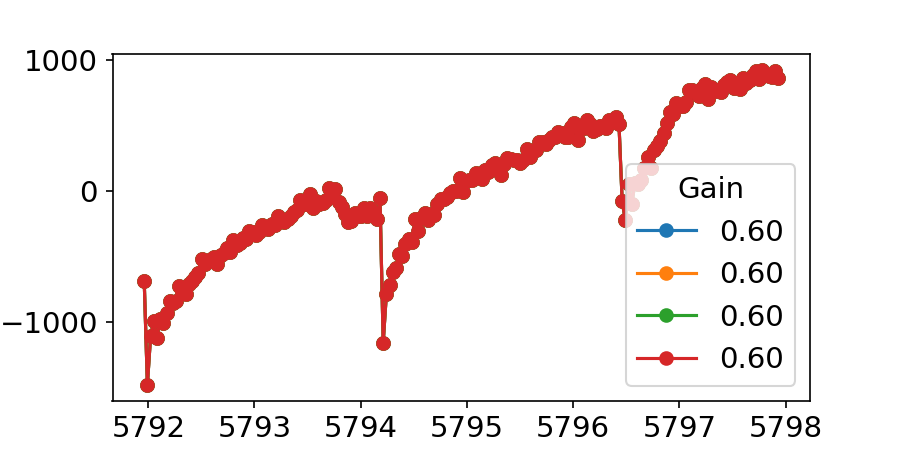

Saving S:\QRAM\qram_4QR2\data\data_240617\00000_power_sweep_resonator_spectroscopy_qubit1.h5


In [794]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec.cfg.expt.qTest)
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False, select=[0.6, 0.7, 0.8, 0.85])  

rpowspec.save_data() 

In [795]:
rpowspec_e.data.keys()

dict_keys(['xpts', 'gainpts', 'avgi', 'avgq', 'amps', 'phases'])

In [796]:
data_g = rpowspec.data
amp_g = rpowspec.data['amps']
avgi_g = rpowspec.data['avgi']
avgq_g = rpowspec.data['avgq']

### E state

In [797]:
rpowspec_e = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

rpowspec_e.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.66, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_gain=start_gain, # Gain start value
    step_gain=step_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=reps, # Number averages per point
    pulse_e=True, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
)
rpowspec_e.cfg.device.readout.relax_delay = 400 # Wait time between experiments [us]
rpowspec_e.cfg.device.readout.readout_length = 3

print(rpowspec_e.cfg)

rpowspec_e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0252717544333, 5794.961666663333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.01, 0.03, 0.01, 0.035], 'readout_length': 3, 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': 400}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.497481224433, 4572.395355534644, 0.0, 4211.655959517836, 4207.2388111170285, 0.0, 4209.981140744554], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.908045977012, 

  0%|          | 0/11 [00:00<?, ?it/s]

qubit 1


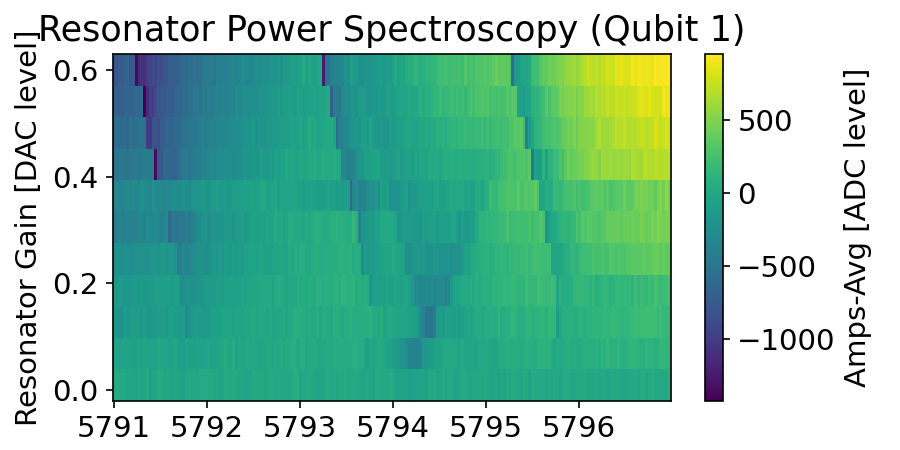

plotting at gain 0.010000000000000009 index 10
plotting at gain 0.06900000000000006 index 9
plotting at gain 0.128 index 8
plotting at gain 0.187 index 7
plotting at gain 0.305 index 5
plotting at gain 0.6 index 0
plotting at gain 0.6 index 0


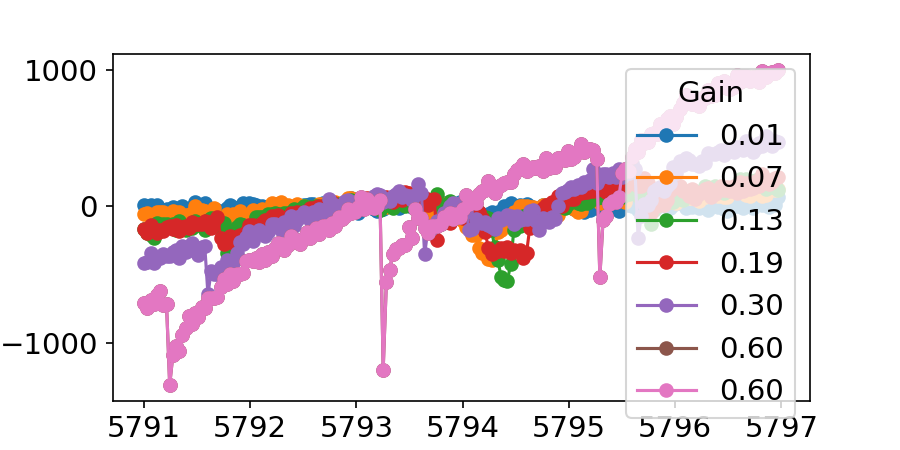

Saving S:\QRAM\qram_4QR2\data\data_240617\00001_power_sweep_resonator_spectroscopy_qubit1.h5


In [798]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec_e.cfg.expt.qTest)
rpowspec_e.analyze(fit=False, lowgain=None, highgain=None)
rpowspec_e.display(fit=False, select=[0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.9])

rpowspec_e.save_data()

In [799]:
data_e = rpowspec_e.data
amp_e = rpowspec_e.data['amps']

avgi_e = rpowspec_e.data['avgi']
avgq_e = rpowspec_e.data['avgq']

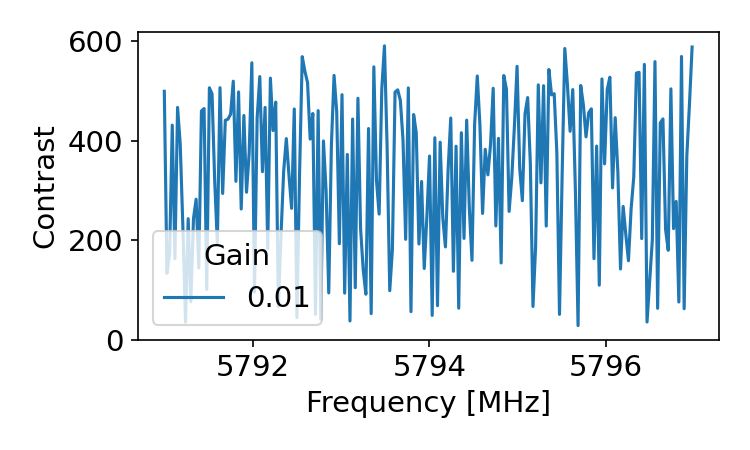

In [801]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
contrast = np.abs(amp_e - amp_g)
contrast = np.sqrt((avgi_g - avgi_e)**2 + (avgq_g - avgq_e)**2)

gain_plot = np.array([0.01])
idx_plot = np.array([np.argmin(np.abs(data_e['gainpts'] - g)) for g in gain_plot])

# nb_plot = 10
# idx_plot = np.linspace(0, len(data_e['gainpts'])-1, nb_plot).astype(int)



[ax.plot(data_e['xpts'], contrast[i], label=f'{data_e["gainpts"][i]:.2f}') for i in (idx_plot)]

ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Contrast')

ax.legend(title='Gain')

fig.tight_layout()

# Single shots

In [79]:
qubit_i = 3

shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=20000,
    check_e=True,
    check_f=False,
    qTest=qubit_i,
)




# shot.cfg.device.readout.frequency[qubit_i]= 5794.52
# shot.cfg.device.readout.gain[qubit_i]= 0.16
# shot.cfg.device.readout.readout_length[qubit_i] = 1
shot.cfg.device.readout.relax_delay = 500  # Wait time between experiments [us]
# set the gains 

print('qubit', shot.cfg.expt.qTest)
print('readout params', shot.cfg.device.readout)

shot.go(analyze=False, display=False, progress=True, save=False)

qubit 3
readout params {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-392.35, 5794.5, 500, -230.5], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.5, 0.12, 0.5, 0.2], 'readout_length': [5, 5, 5, 5], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': 500}


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

{'device': {'readout': {'trig_offset': [145, 145, 145, 145], 'lo_sideband': [1, 1, 1, 1], 'frequency': [-392.35, 5794.5, 500, -230.5], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.5, 0.12, 0.5, 0.2], 'readout_length': [5, 5, 5, 5], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [500, 500, 500, 500]}, 'qubit': {'f_ge': [4110.8505860455725, 4105.048189664584, 4110.198576889643, 4109.870151106654, 3442.8095108490056, 3448.3298699370694, 3447.0857887636976, 3446.8874200312653, 4762.060705219546, 4761.102749662887, 4762.201572322125, 4761.678033261405, 4381.14185795623, 4380.370331938204, 4381.142621732222, 4381.679544300405], 'f_ef': [3884.3737933985267, 0.0, 0.0, 0.0, 0.0, 3347.761789059698, 0.0, 0.0, 4571.9056482340775, 4570.497481224433, 4572.395355534644, 0.0, 4211.655959517836, 4207.2388111170285, 0.0, 4209.981140744554], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.908045977012,

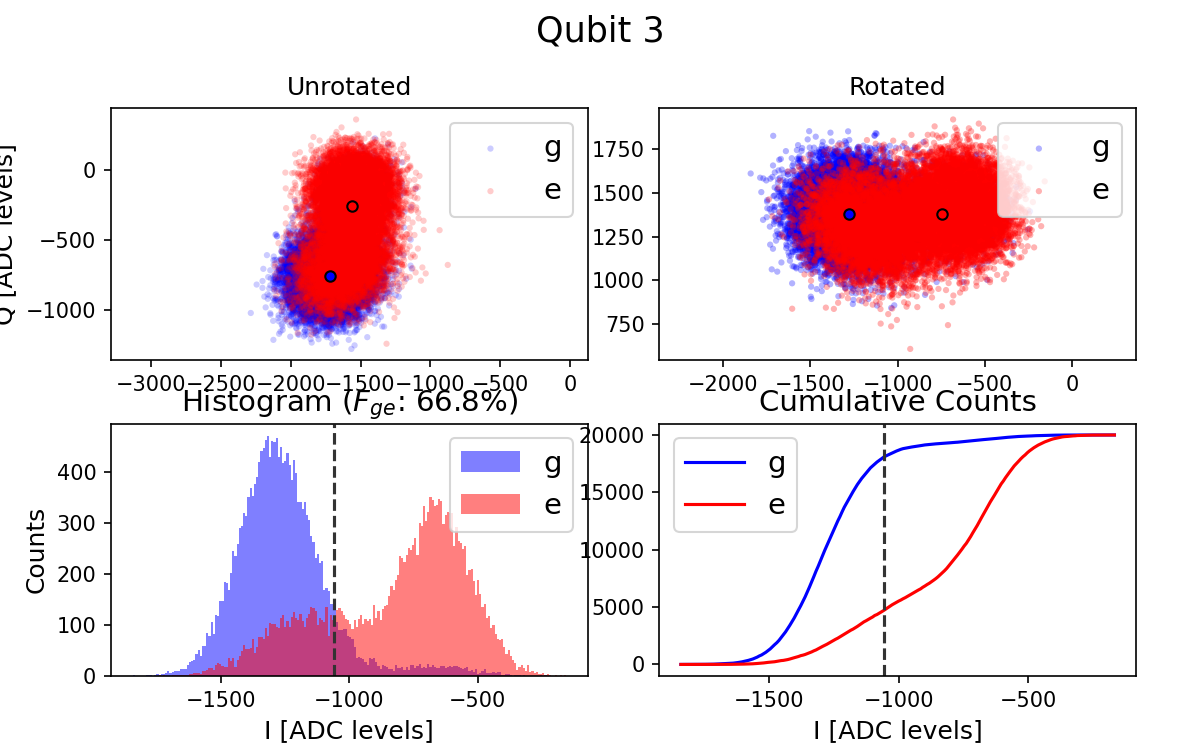

ge fidelity (%): 66.82000000000001
rotation angle (deg): -70.96948338080942
threshold ge: -1058.755310633319


In [80]:
print(shot.cfg)
shot.display(fit=False) 

## sweeps

In [42]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))


qubit_i = 3

span_f = 1
npts_f = 50
start_f = shotopt.cfg.device.readout.frequency[qubit_i]-span_f*0.5


start_gain = 0.15
stop_gain = 0.30
npts_gain = 10
step_gain = (stop_gain - start_gain) / npts_gain

span_len = 6 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=1000,
    qTest=qubit_i,
    start_f=start_f, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=start_gain,
    step_gain=step_gain,
    expts_gain=npts_gain + 1,
    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

shotopt.go(analyze=False, display=False, progress=True, save=False)

[-231.5  -231.48 -231.46 -231.44 -231.42 -231.4  -231.38 -231.36 -231.34
 -231.32 -231.3  -231.28 -231.26 -231.24 -231.22 -231.2  -231.18 -231.16
 -231.14 -231.12 -231.1  -231.08 -231.06 -231.04 -231.02 -231.   -230.98
 -230.96 -230.94 -230.92 -230.9  -230.88 -230.86 -230.84 -230.82 -230.8
 -230.78 -230.76 -230.74 -230.72 -230.7  -230.68 -230.66 -230.64 -230.62
 -230.6  -230.58 -230.56 -230.54 -230.52]
[0.15  0.165 0.18  0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3  ]
[3.]


  0%|          | 0/50 [00:00<?, ?it/s]

freq: -231.5, gain: 0.15, len: 3.0
	fid ge [%]: 11.0
freq: -231.5, gain: 0.16499999999999998, len: 3.0
	fid ge [%]: 12.312312312312311
freq: -231.5, gain: 0.18, len: 3.0
	fid ge [%]: 14.099999999999998
freq: -231.5, gain: 0.195, len: 3.0
	fid ge [%]: 16.50825412706353
freq: -231.5, gain: 0.21, len: 3.0
	fid ge [%]: 11.0
freq: -231.5, gain: 0.22499999999999998, len: 3.0
	fid ge [%]: 14.399999999999999
freq: -231.5, gain: 0.24, len: 3.0
	fid ge [%]: 17.1
freq: -231.5, gain: 0.255, len: 3.0
	fid ge [%]: 15.8
freq: -231.5, gain: 0.27, len: 3.0
	fid ge [%]: 18.209104552276138
freq: -231.5, gain: 0.28500000000000003, len: 3.0
	fid ge [%]: 17.508754377188595
freq: -231.5, gain: 0.3, len: 3.0
	fid ge [%]: 18.8
freq: -231.48, gain: 0.15, len: 3.0
	fid ge [%]: 11.700000000000001
freq: -231.48, gain: 0.16499999999999998, len: 3.0
	fid ge [%]: 11.5
freq: -231.48, gain: 0.18, len: 3.0
	fid ge [%]: 11.0
freq: -231.48, gain: 0.195, len: 3.0
	fid ge [%]: 13.806903451725864
freq: -231.48, gain: 0.21, l

(49, 8, 0)
[-231.5  -231.48 -231.46 -231.44 -231.42 -231.4  -231.38 -231.36 -231.34
 -231.32 -231.3  -231.28 -231.26 -231.24 -231.22 -231.2  -231.18 -231.16
 -231.14 -231.12 -231.1  -231.08 -231.06 -231.04 -231.02 -231.   -230.98
 -230.96 -230.94 -230.92 -230.9  -230.88 -230.86 -230.84 -230.82 -230.8
 -230.78 -230.76 -230.74 -230.72 -230.7  -230.68 -230.66 -230.64 -230.62
 -230.6  -230.58 -230.56 -230.54 -230.52]
[0.15  0.165 0.18  0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3  ]
[3.]
Max fidelity 79.4 %
Set params: 
 angle (deg) 59.4171034888827 
 threshold -1360.2003455630374 
 freq [Mhz] -230.52 
 gain [dac units] 0.27 
 readout length [us] 3.0
Optimal readout length 3.0 us
(50, 11, 1) (11,) (50,) (1,)


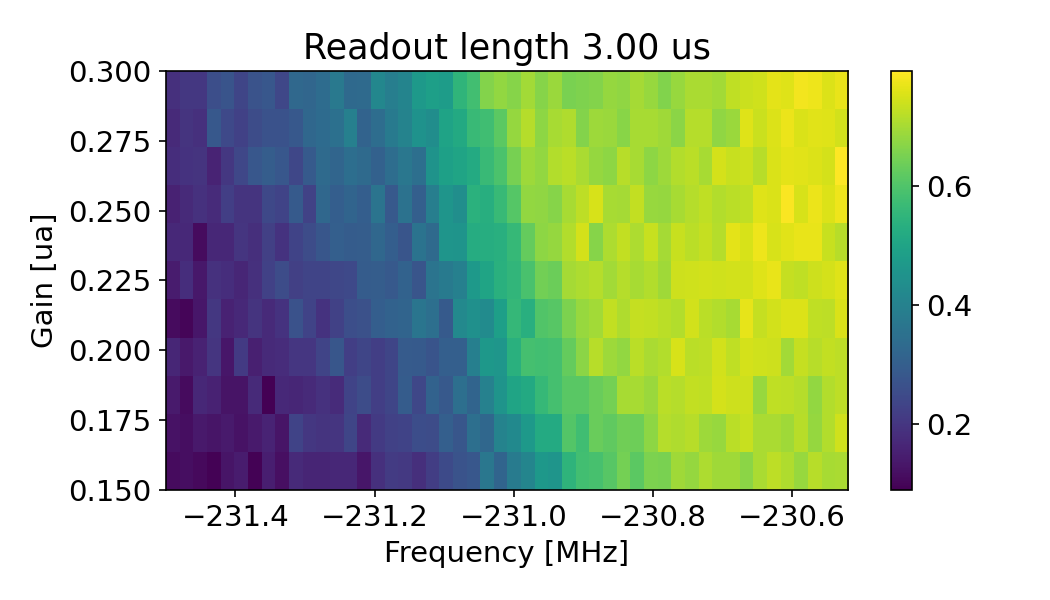

In [43]:
imax = shotopt.analyze()

print(f'Optimal gain {shotopt.data["gainpts"][imax[1]]},  frequency {shotopt.data["fpts"][imax[0]]} MHz' and f'Optimal readout length {shotopt.data["lenpts"][imax[2]]} us')


# shotopt.display()
fid = shotopt.data['fid']
gain = shotopt.data['gainpts']
fpts = shotopt.data['fpts']
lenpts = shotopt.data['lenpts']

print(fid.shape, gain.shape, fpts.shape, lenpts.shape)


# print 2d plot of the fidelity versus gain and frequency for each readout length
# fid is a 3d array with shape (len(fpts), len(gain), len(lenpts))

for i in range(len(lenpts)):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.imshow(fid[:, ::-1, i].T, aspect='auto', extent=[fpts[0], fpts[-1], gain[0], gain[-1]])
    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Gain [ua]')
    ax.set_title(f'Readout length {lenpts[i]:.2f} us')
    # add colorbar
    ax.figure.colorbar(ax.images[0], ax=ax)
    fig.tight_layout()



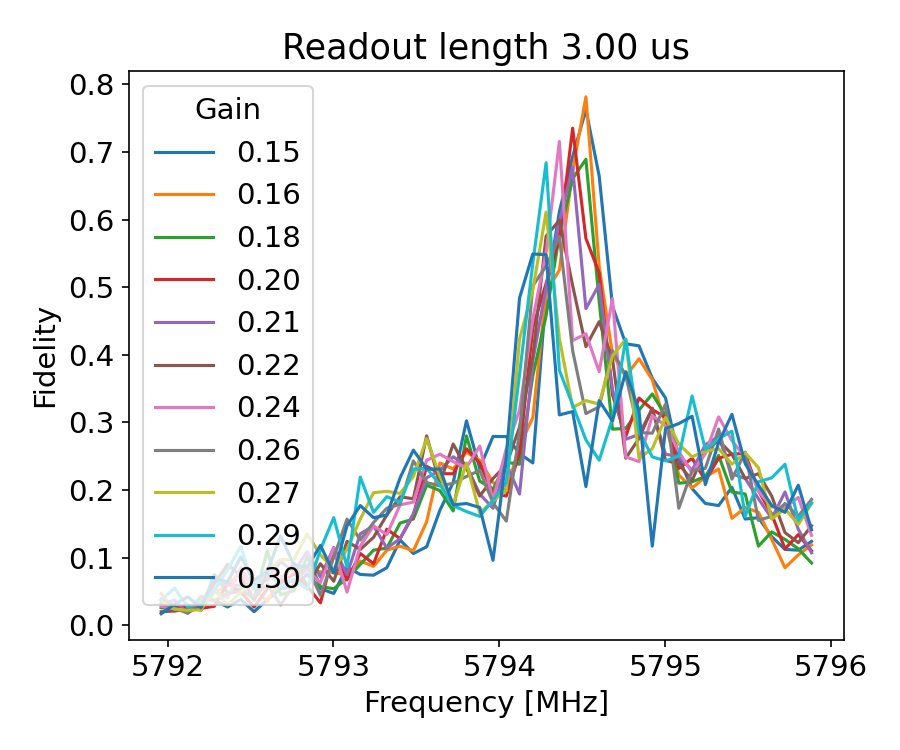

In [806]:
# plot the slice for the longest readout length


for l in lenpts:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    [ax.plot(fpts, fid[:, i, np.argmin(np.abs(lenpts - l))], label=f'{gain[i]:.2f}') for i in range(len(gain))]

    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Fidelity')
    ax.legend(title='Gain')
    ax.set_title(f'Readout length {l:.2f} us')
    fig.tight_layout()

# fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# [ax.plot(fpts, fid[:, i, -1], label=f'{gain[i]:.2f}') for i in range(len(gain))]

# ax.set_xlabel('Frequency [MHz]')
# ax.set_ylabel('Fidelity')
# ax.legend(title='Gain')

# fig.tight_layout()

In [732]:
shotopt.save_data()

Saving S:\QRAM\qram_4QR2\data\data_240617\00000_single_shot_opt_qubit2.h5


'S:\\QRAM\\qram_4QR2\\data\\data_240617\\00000_single_shot_opt_qubit2.h5'

## Multi-readout

gain 0.2 readout length 5
qubit 3


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

sync delay us 1.9996279761904763


  0%|          | 0/20000 [00:00<?, ?it/s]

sync delay us 1.9996279761904763


  0%|          | 0/20000 [00:00<?, ?it/s]

dict_keys(['Ig_baseline', 'Qg_baseline', 'Ie_baseline', 'Qe_baseline', 'Ig', 'Qg', 'Ie', 'Qe', 'iqshots', 'ge_avgs'])
wheres my plot


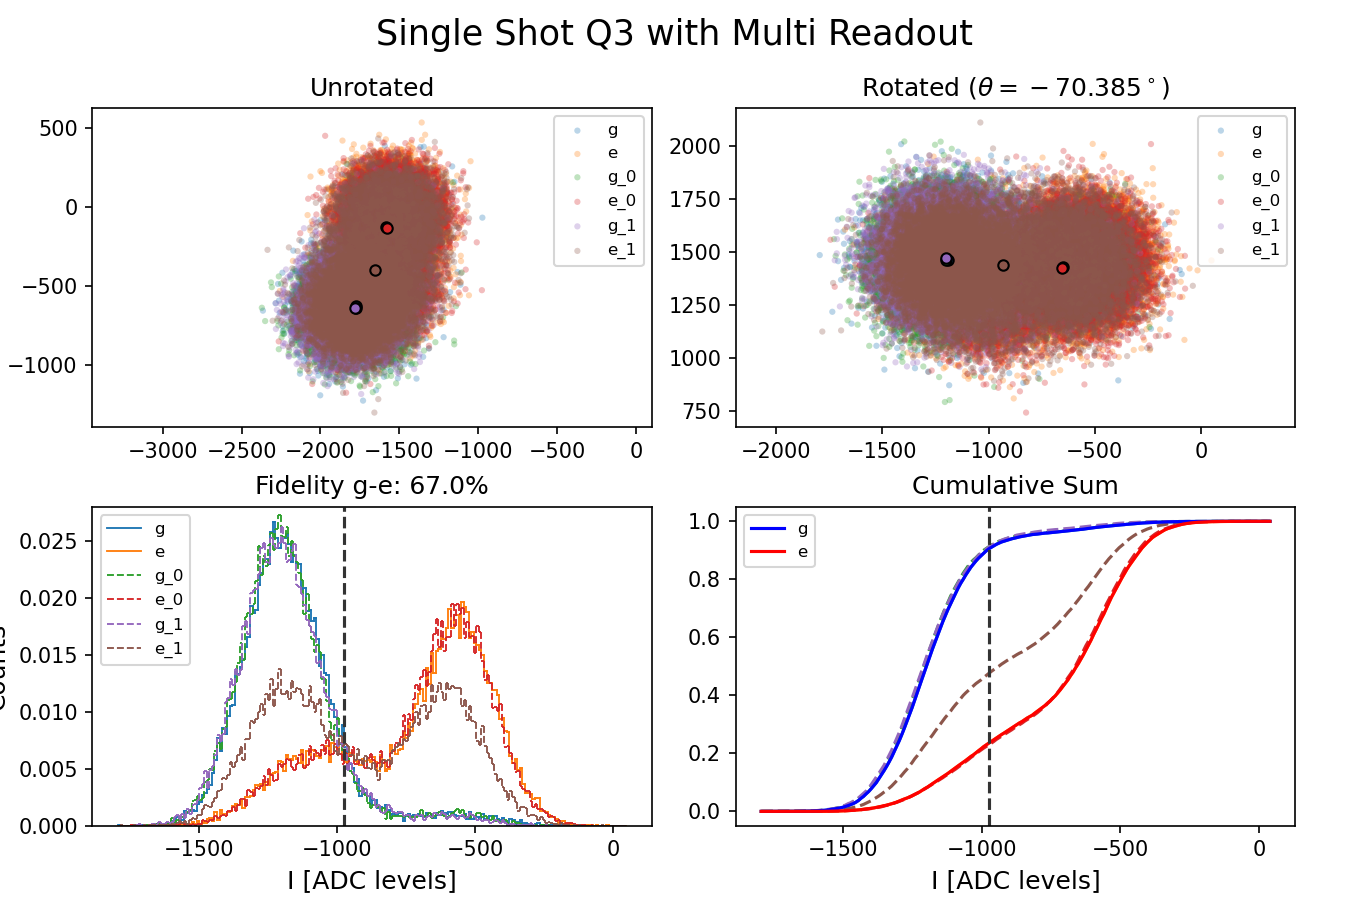

Saving S:\QRAM\qram_4QR2\data\data_240617\00180_multi_readout_qubit3.h5
gain 0.2 readout length 5
qubit 3


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

sync delay us 29.999069940476193


  0%|          | 0/20000 [00:00<?, ?it/s]

sync delay us 29.999069940476193


  0%|          | 0/20000 [00:00<?, ?it/s]

dict_keys(['Ig_baseline', 'Qg_baseline', 'Ie_baseline', 'Qe_baseline', 'Ig', 'Qg', 'Ie', 'Qe', 'iqshots', 'ge_avgs'])
wheres my plot


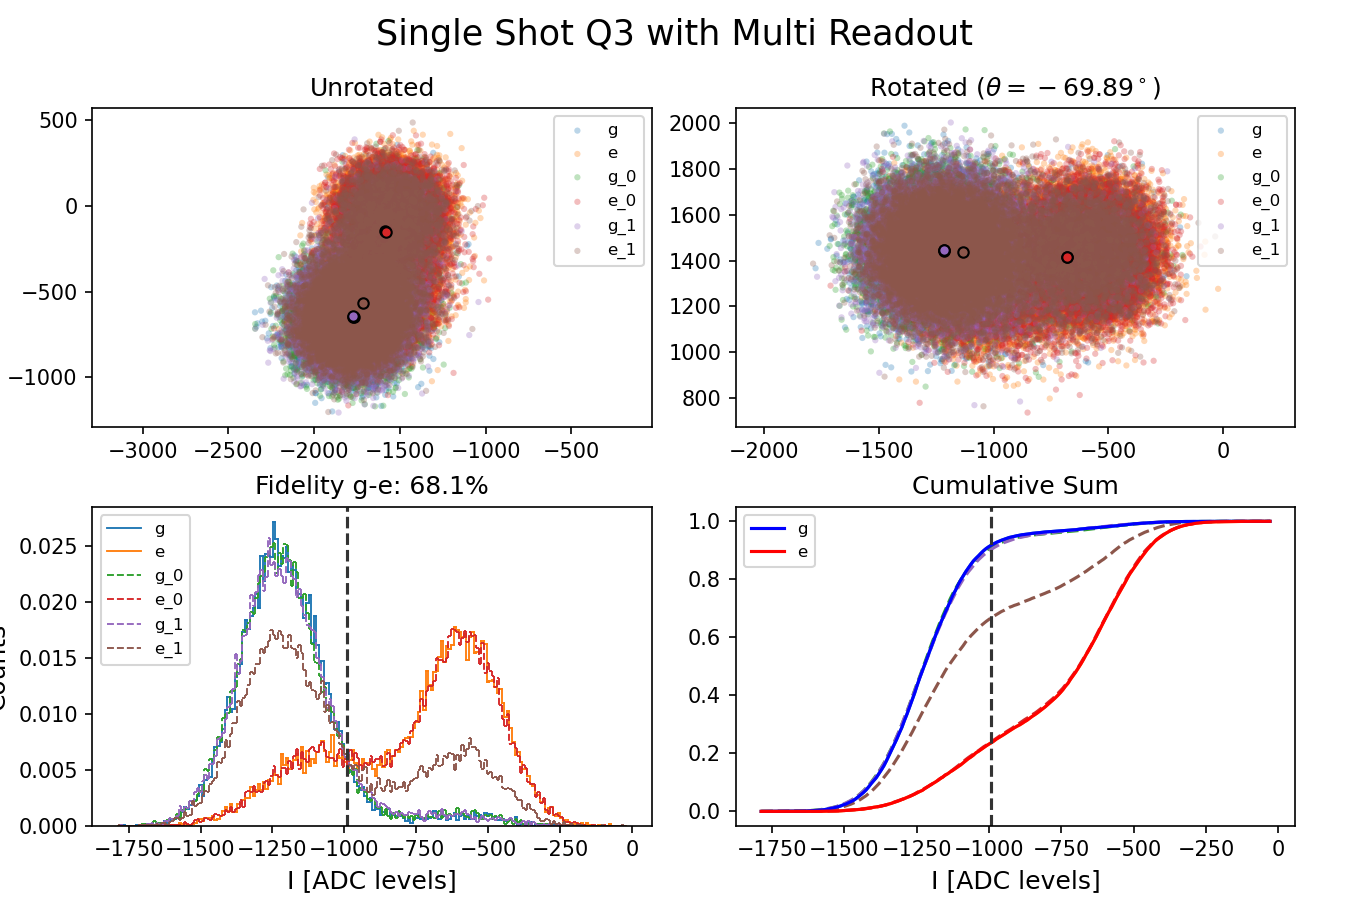

Saving S:\QRAM\qram_4QR2\data\data_240617\00181_multi_readout_qubit3.h5


In [66]:
qubit_i = 3
gain_vec = np.array([0.20])
readout_vec = np.array([5])
wait_vec = np.array([2, 30])
n_trig = np.array([1])
freq = -230.5


for t in n_trig:
    for w in wait_vec:
        for r in readout_vec:
            for g in gain_vec:
                print('gain', g, 'readout length', r)
                
                shot = meas.MultiReadoutExperiment(
                    soccfg=soc,
                    path=expt_path,
                    prefix=f"multi_readout_qubit{qubit_i}",
                    config_file=config_path,
                )

                shot.cfg.expt = dict(
                    reps=20000,
                    check_e=True,
                    check_f=False,
                    qTest=qubit_i,

                    readout_cool=True,
                    n_init_readout=1, # number of readout blocks prior to final readout
                    n_trig=t, # extend readout by triggering this many times in a row
                    init_read_wait_us=w, # wait between readout blocks

                    use_gf_readout=False,
                    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
                )

                shot.cfg.device.readout.readout_length[0] = r
                shot.cfg.device.readout.readout_length[1] = r
                shot.cfg.device.readout.readout_length[2] = r
                shot.cfg.device.readout.readout_length[3] = r
                shot.cfg.device.readout.frequency[qubit_i]= freq
                shot.cfg.device.readout.gain[qubit_i] = g
                print('qubit', shot.cfg.expt.qTest)

                try:
                    shot.go(analyze=False, display=False, progress=True, save=False)
                except Exception:
                    print("Pyro traceback:")
                    print("".join(Pyro4.util.getPyroTraceback()))
                    
                shot.analyze(fit=False, check_readouts=[0, 1], post_select=False, verbose=False)
                shot.display(fit=False, post_select=False, verbose=False, export=False)
                
                shot.save_data()
                